In [325]:
import os
import io
import gpxpy
import folium
import selenium
import requests
import numpy as np
import pandas as pd
import sqlite3 as sq
import seaborn as sb
import osmnx as ox
import matplotlib.pyplot as plt


from PIL import Image
from scipy.stats import normaltest, shapiro, kstest
from geopy.distance import geodesic
from ipywidgets import IntProgress
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [35]:
def parse_gpx(gpx_string, track_id):
    try:
        gpx = gpxpy.parse(gpx_string)
    except Exception as e:
        print(e)
        return None
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                            'track_id': track_id,
                            'latitude': point.latitude,
                            'longitude': point.longitude,
                            'elevation': point.elevation,
                            'time': point.time,
                            'name': track.name
                        })
    return points

In [156]:
def length(parsed_gpx):
    length_3d = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        length_track = 0
        for idx in track.index[:-1]:
            p1 = (track['latitude'][idx], track['longitude'][idx])
            p2 = (track['latitude'][idx + 1], track['longitude'][idx + 1])
            length_2d = geodesic(p1, p2).meters
            if pd.notna(track['elevation'][idx]):
                length_track = np.sqrt((length_2d ** 2) + (track['elevation'][idx] - track['elevation'][idx + 1]) ** 2)
            else:
                length_track = length_2d
            length_3d.append(length_track)
        length_3d.append(None)
    return length_3d

In [37]:
def time_delta(parsed_gpx):
    time_delta = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        for idx in track.index[:-1]:
            time_delta.append(track['time'][idx + 1] - track['time'][idx])
        time_delta.append(None)
    return time_delta

In [48]:
def mean_day_temp(lat, lon, time):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
    	"latitude": lat,
    	"longitude": lon,
    	"start_date": time,
    	"end_date": time,
    	"daily": "temperature_2m_mean",
    }
    response = requests.get(url, params=params)
    return response.json()['daily']['temperature_2m_mean']

In [261]:
def temp_per_track(parsed_gpx):
    temp = []
    bar = IntProgress(min=0, max=len(parsed_gpx['track_id'].unique()))
    display(bar)
    for track in parsed_gpx.groupby('track_id'):
        track = track[1]
        if pd.notna(track['time']).sum():
            id = track.index[0]
            test = mean_day_temp(track['latitude'][id], track['longitude'][id], str(track['time'][id])[:10])
            temp.append(test[0])
        else:
            temp.append(None)
        bar.value += 1
    return temp

In [262]:
def parse_features(lat, lon, radius=500):
    point = (lat, lon)
    tags = {
        "water": {"natural": "water"},
        "forest": {"natural": "wood"},
        "buildings": {"building": True}
    }
    
    features = {}
    for key, tag in tags.items():
        try:
            gdf = ox.features.features_from_point(point, dist=radius, tags=tag)
            features[key] = len(gdf)
        except Exception as e:
            features[key] = 0
    
    return features

In [251]:
def get_features(parsed_gpx, n=3):
    bar = IntProgress(min=0, max=len(parsed_gpx.index))
    display(bar)
    water = []
    forest = []
    buildings = []
    features = parse_features(parsed_gpx['latitude'][0], parsed_gpx['longitude'][0])
    for idx in parsed_gpx.index:
        if idx % n == 0:
            features = parse_features(parsed_gpx['latitude'][idx], parsed_gpx['longitude'][idx])
        water.append(features['water'])
        forest.append(features['forest'])
        buildings.append(features['buildings'])
        bar.value += 1
    return water, forest, buildings

In [246]:
def around_type(df):
    if pd.notna(df[['water', 'forest', 'buildings' ]]).sum() and df[['water', 'forest', 'buildings' ]].sum():
        if df['water'] + df['forest'] > 0:
            around = {'water': df['water'], 'forest': df['forest']}
            return max(around, key=around.get)
        if df['buildings'] > 0:
            return 'city'
    return None

In [256]:
class Agent:
    def __init__(self, path_to_db:str, path_to_maps:str):
        self.path_to_db = path_to_db
        self.path_to_maps = path_to_maps

    def save_data(self):
        try:
            conn = sq.connect(self.path_to_db)
            self.data.to_sql("data", con=conn, if_exists="replace", index=False)
            conn.close()
        except Exception as e:
            print(e)

    def parse_paths(self, paths:list[str]):
        # загружаем gpx файлы и создаём датафрейм
        all_points = []
        trace_id = []
        self.idx = 0
        for path in paths:
            gpx = open(path, 'r')
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"Создан dataframe с {len(parsed_gpx['track_id'].unique())} маршрутами")
        self.data = parsed_gpx

    def add_gpx(self, gpx_strings:list[str]):
        all_points = []
        for gpx in gpx_strings:
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"В датасет добавлены {len(parsed_gpx['track_id'].unique())} маршрутов")
        self.data = pd.concat([self.data, parsed_gpx], ignore_index=True)

    def fill_dataset(self):
        parsed_gpx = self.data
        
        # Просчитываем расстояния между точками
        length_3d = length(parsed_gpx)
        parsed_gpx['length_3d'] = length_3d
        print("Посчитанны расстояния между точками")
    
        # Расчитываем время между точками
        parsed_gpx['time_delta'] = time_delta(parsed_gpx)
        print("Просчитано время между точками")
    
        # Просчитываем частоту шагов
        parsed_gpx['step_frequency'] = parsed_gpx.apply(lambda parsed_gpx: (parsed_gpx['length_3d'] / 0.75) / parsed_gpx['time_delta'].total_seconds(), axis=1)
        print("Просчитана частота шагов")
    
        print('Просчитываем температуру для каждого трека')
        temp = temp_per_track(parsed_gpx)
        parsed_gpx['tempurture'] = parsed_gpx['track_id'].map(lambda x: temp[x])
        print("Просчитана температура для каждого трека")

        n=6
        print(f'Парсим обьекты вокруг каждой {n} точки и определяем тип местности')
        water, forest, buildings = get_features(parsed_gpx, n=n)
        parsed_gpx['water'] = water + [None] * (len(parsed_gpx) - len(water))
        parsed_gpx['forest'] = forest + [None] * (len(parsed_gpx) - len(forest))
        parsed_gpx['buildings'] = buildings + [None] * (len(parsed_gpx) - len(buildings))
        parsed_gpx['type'] = parsed_gpx.apply(around_type, axis=1)
        
        self.data = parsed_gpx

    def gen_img(self):
        for track in self.data.groupby('track_id'):
            track = track[1]
            idx = round(track['track_id'].mean())
            m = folium.Map(location=[track['latitude'].mean(), track['longitude'].mean()], zoom_start=14)
            folium.PolyLine(track[['latitude', 'longitude']].values, tooltip="Coast").add_to(m)
            print(f"Карта маршрута {idx}")
            display(m)
            img_data = m._to_png(5)
            img = Image.open(io.BytesIO(img_data))
            img.save(os.path.join(self.path_to_maps, f'{idx}.png'))
        

In [263]:
agent = Agent("data.db", "Maps/")
agent.parse_paths(['datasets/1.gpx', 'datasets/2.gpx'])

Создан dataframe с 2 маршрутами


In [255]:
gpx_data = pd.read_csv("datasets/gpx-tracks-from-hikr.org.csv")

In [264]:
agent.add_gpx(list(gpx_data['gpx'][:4]))

В датасет добавлены 4 маршрутов


In [265]:
agent.fill_dataset()

Посчитанны расстояния между точками
Просчитано время между точками
Просчитана частота шагов
Просчитываем температуру для каждого трека


IntProgress(value=0, max=6)

Просчитана температура для каждого трека
Парсим обьекты вокруг каждой 6 точки и определяем тип местности


IntProgress(value=0, max=1079)

In [267]:
agent.gen_img()

Карта маршрута 0


Карта маршрута 1


Карта маршрута 2


Карта маршрута 3


Карта маршрута 4


Карта маршрута 5


In [333]:
agent.save_data()

C:\Users\demoexam\AppData\Local\Temp\ipykernel_4048\253894976.py:9: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  self.data.to_sql("data", con=conn, if_exists="replace", index=False)


In [178]:
agent.data.describe()

,track_id,latitude,longitude,elevation,length_3d,time_delta,step_frequency,tempurture,water,forest,buildings
count,1079.000000,1079.000000,1079.000000,1079.000000,1073.000000,1073,1073.000000,1079.000000,1079.000000,1079.00000,1079.000000
mean,3.153846,46.896205,10.723159,1282.052132,87.840523,0 days 00:01:59.671015843,1.195098,12.577850,0.693234,0.63392,93.255792
std,1.719273,0.420351,2.273092,593.305750,66.650406,0 days 00:02:03.364180212,0.542122,3.070317,1.011740,1.57685,208.491644
min,0.000000,46.179897,8.278574,176.540000,10.454730,0 days 00:00:09,0.048440,8.900000,0.000000,0.00000,0.000000
25%,2.000000,46.228573,8.418583,691.805000,44.169113,0 days 00:00:54,0.773571,10.400000,0.000000,0.00000,2.000000
50%,4.000000,46.996962,8.991198,1408.380000,73.926906,0 days 00:01:31,1.204727,13.300000,0.000000,0.00000,8.000000
75%,5.000000,47.228016,13.170451,1816.360000,115.468915,0 days 00:02:22,1.633925,17.000000,1.000000,0.50000,79.000000
max,5.000000,47.262924,13.242523,2265.000000,636.150957,0 days 00:29:56,4.104465,17.000000,7.000000,11.00000,1180.000000


In [179]:
agent.data.isnull().sum()

track_id           0
latitude           0
longitude          0
elevation          0
time               0
name               0
length_3d          6
time_delta         6
step_frequency     6
tempurture         0
water              0
forest             0
buildings          0
type              99
dtype: int64

In [180]:
agent.data['track_id'].unique()

array([0, 1, 2, 3, 4, 5])

## length_3d

<Axes: xlabel='length_3d', ylabel='Count'>

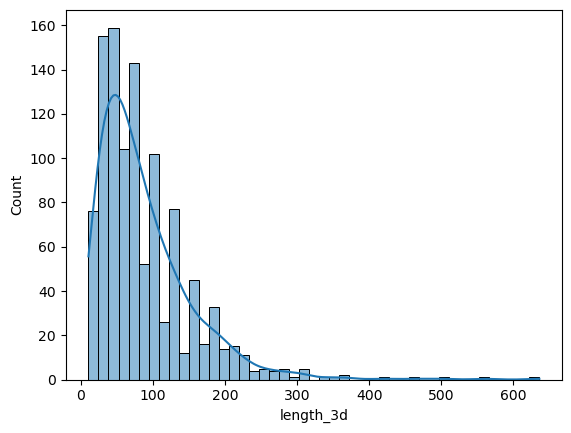

In [269]:
sb.histplot(agent.data['length_3d'], kde=True)

In [296]:
res = normaltest(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [297]:
res = shapiro(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [329]:
res = kstest(agent.data['length_3d'], 'expon')
print(res.statistic)
print(res.pvalue)

nan
nan


## time_delta

<Axes: xlabel='time_delta', ylabel='Count'>

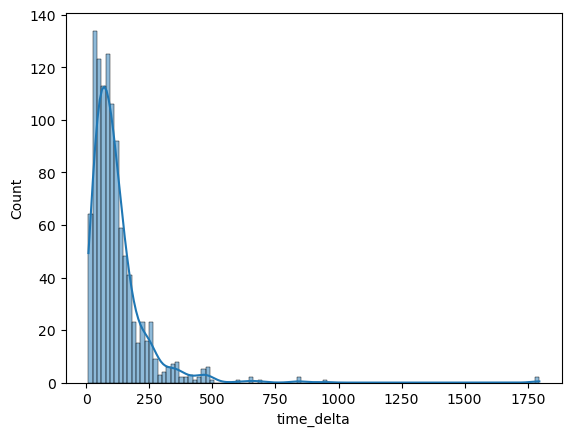

In [292]:
sb.histplot(agent.data['time_delta'].map(lambda x: x.seconds), kde=True)

In [298]:
res = normaltest(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

nan
nan


In [299]:
res = shapiro(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

nan
nan


In [331]:
res = kstest(agent.data['time_delta'].map(lambda x: x.seconds), "expon")
print(res.statistic)
print(res.pvalue)

nan
nan


## tempurture

<Axes: xlabel='tempurture', ylabel='Count'>

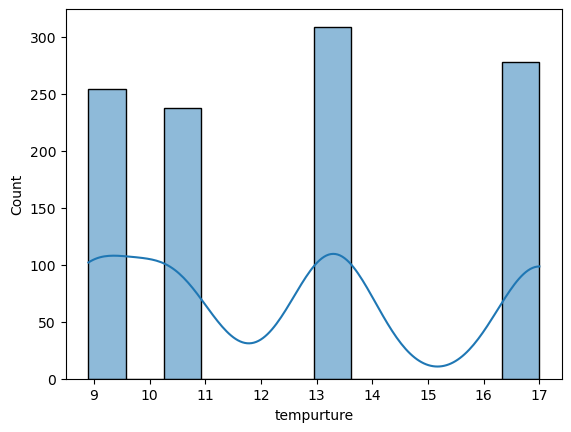

In [300]:
sb.histplot(agent.data['tempurture'], kde=True)

In [303]:
res = normaltest(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

8471.419840828383
0.0


In [304]:
res = shapiro(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

0.8358068942396026
6.492905834859161e-32


## step_frequency

<Axes: xlabel='step_frequency', ylabel='Count'>

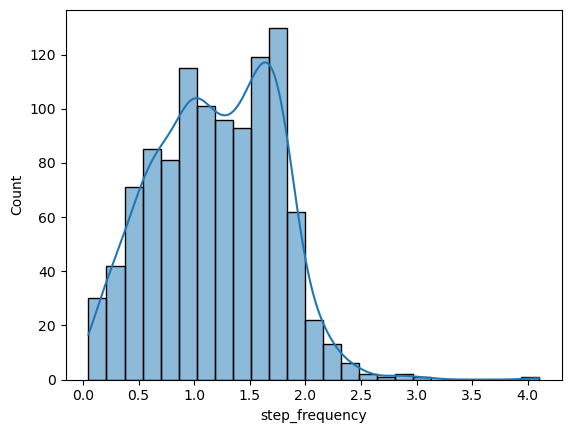

In [305]:
sb.histplot(agent.data['step_frequency'], kde=True)

In [306]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [307]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [332]:
res = kstest(agent.data['step_frequency'], "expon")
print(res.statistic)
print(res.pvalue)

nan
nan


## type

<Axes: xlabel='type', ylabel='Count'>

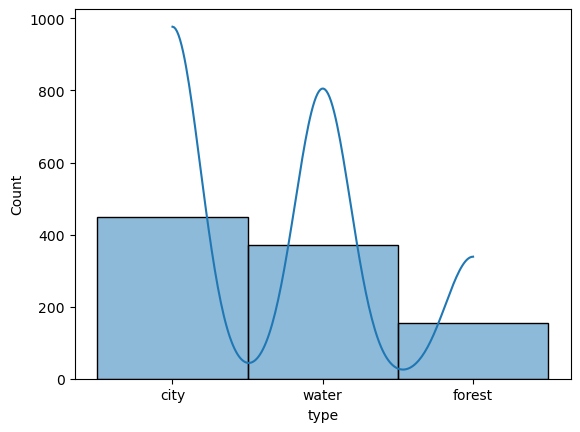

In [308]:
sb.histplot(agent.data['type'], kde=True)

In [317]:
clean = agent.data.dropna()
clean["type"] = clean["type"].map({'city': 0, 'water': 1, 'forest': 2})
res = normaltest(temp['type'])
print(res.statistic)
print(res.pvalue)

220.04720689750474
1.649514521066556e-48


C:\Users\demoexam\AppData\Local\Temp\ipykernel_4048\878810492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean["type"] = clean["type"].map({'city': 0, 'water': 1, 'forest': 2})


In [324]:
clean = agent.data.dropna()
clean["type"] = clean["type"].map({'city': 0, 'water': 1, 'forest': 2})
res = shapiro(temp['type'])
print(res.statistic)
print(res.pvalue)

0.7729003460289878
1.3252095941809585e-34


C:\Users\demoexam\AppData\Local\Temp\ipykernel_4048\1787874180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean["type"] = clean["type"].map({'city': 0, 'water': 1, 'forest': 2})
